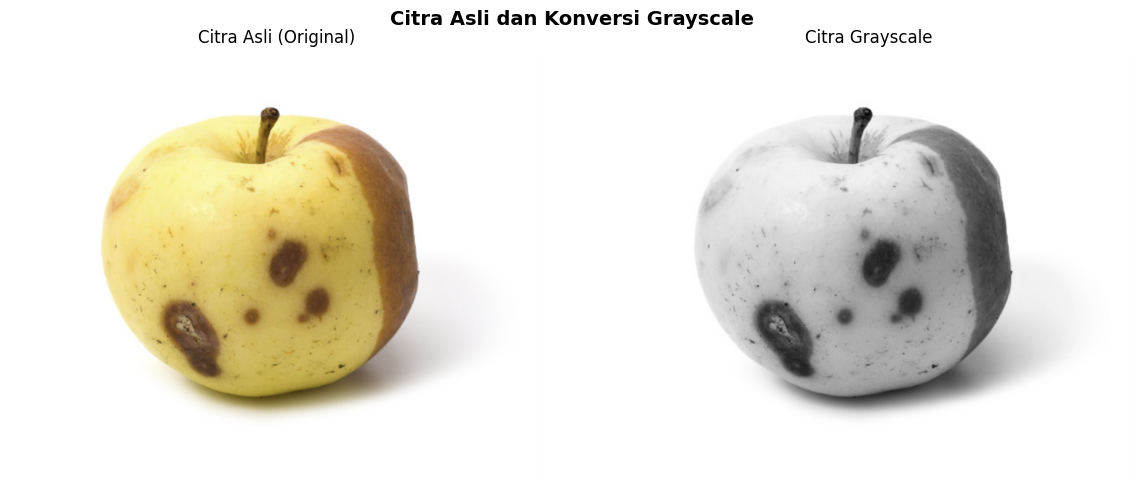


Info citra:
   - Ukuran citra asli (original): (1371, 1682, 3)
   - Ukuran citra grayscale: (1371, 1682)
   - Range intensitas grayscale: 25 - 255
Adaptive Threshold Detection - Piksel cacat: 13320 (0.58%)


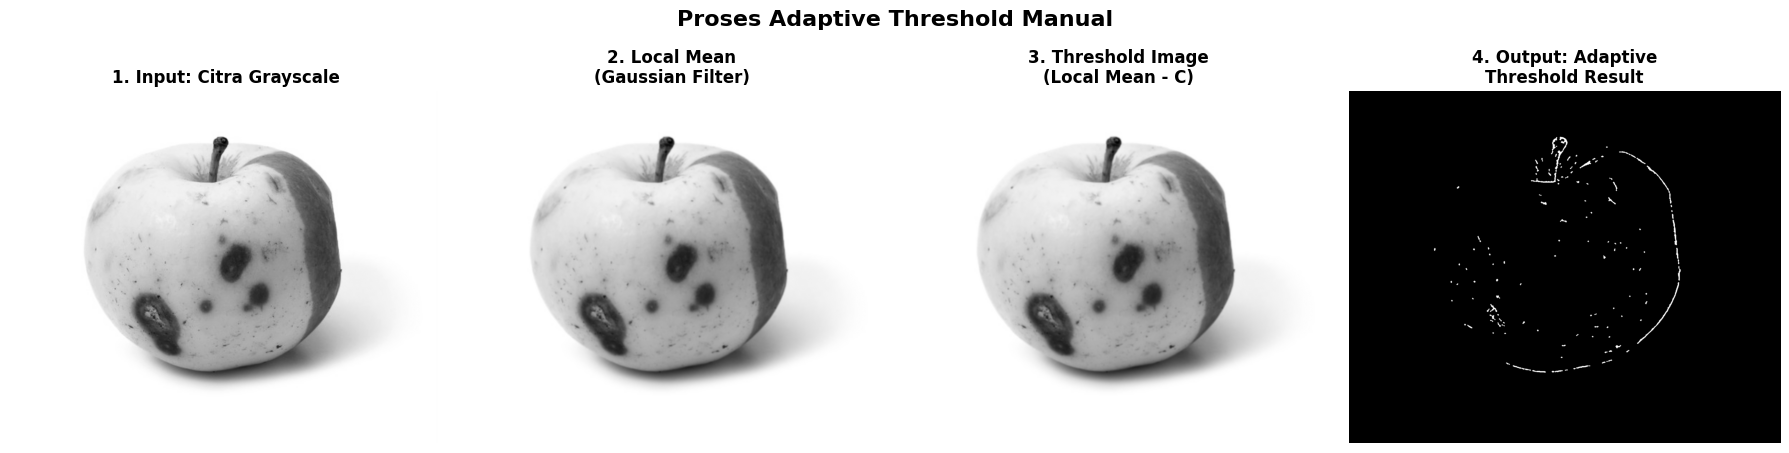


Statistik Adaptive Threshold:
   Parameter yang digunakan:
     • Block size: 11
     • C (konstanta): 2
     • Method: gaussian
     • Type: binary_inv

   Hasil deteksi:
     • Piksel putih (cacat): 13,320 (0.58%)
     • Piksel hitam (normal): 2,292,702 (99.42%)
     • Total piksel: 2,306,022

🔍 Analisis Intensitas:
     • Grayscale - Min: 25, Max: 255, Mean: 227.22
     • Local Mean - Min: 30.10, Max: 255.00, Mean: 227.22
     • Threshold - Min: 28.10, Max: 253.00, Mean: 225.22
Sobel Edge Detection - Piksel tepi: 100478 (4.36%)


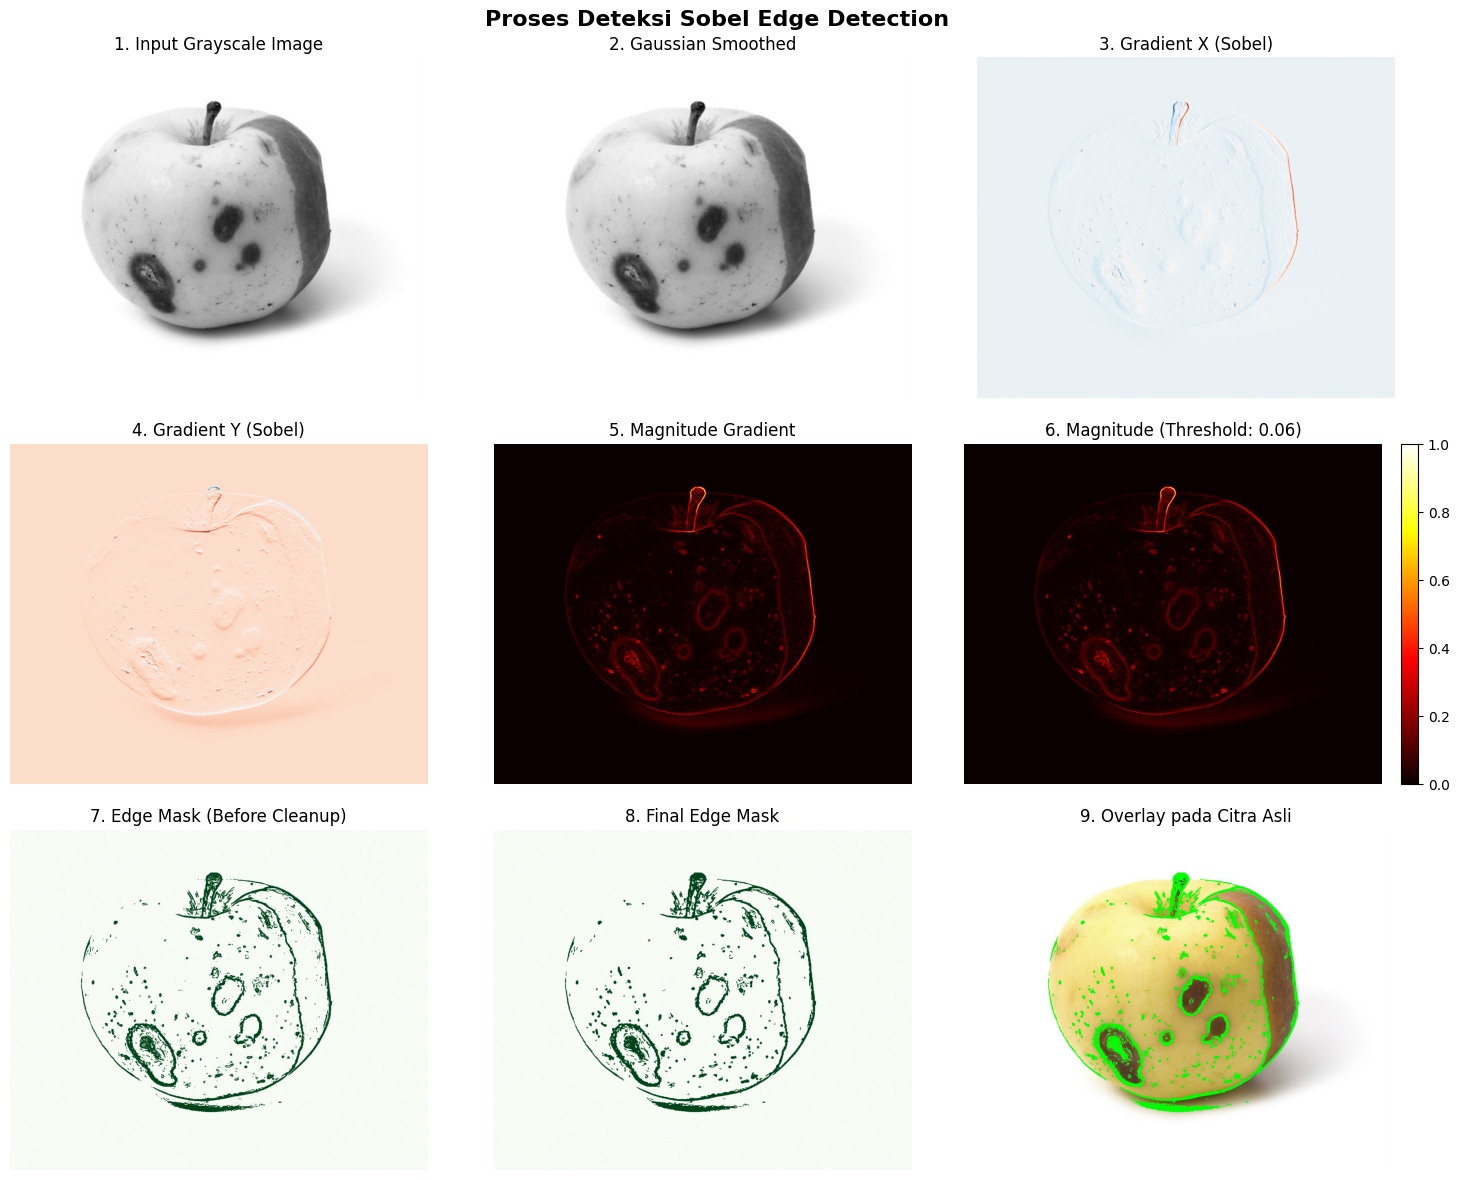


Statistik Detail Deteksi Sobel:
   - Input: Grayscale Image
   - Threshold: 0.06
   - Edge pixels (before cleanup): 99205
   - Edge pixels (after cleanup): 100478
   - Pixels removed by cleanup: -1273
   - Max gradient magnitude: 1.0000
   - Mean gradient magnitude: 0.0114


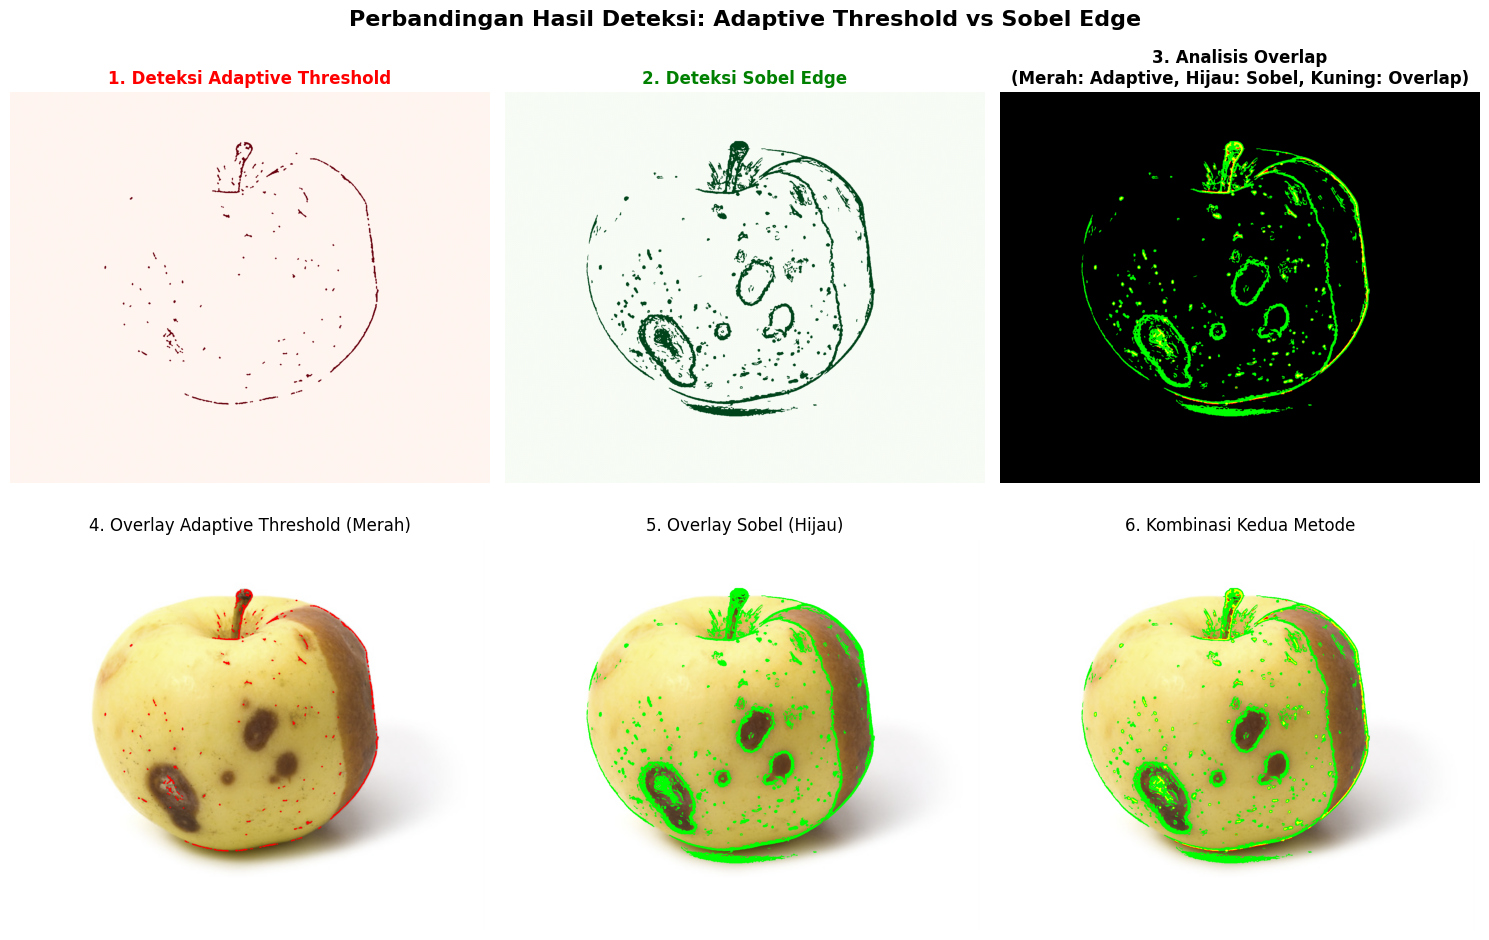


Analisis Overlap:
   - Overlap (kedua metode): 11311 pixels
   - Adaptive Threshold only: 2009 pixels
   - Sobel only: 89167 pixels
   - Total deteksi gabungan: 102487 pixels
   - Persentase overlap: 11.04%

📋 TABEL PERBANDINGAN HASIL:
              Metode  Luas Cacat (px) Persentase (%)  Jumlah Objek Ukuran Rata-rata  Objek Terbesar                        Keunggulan                   Kelemahan
  Adaptive Threshold            13320          0.58%           119            111.9          1869.0 Deteksi area kontras rendah lokal Sensitif terhadap parameter
Sobel Edge Detection           100478          4.36%           237            424.0         25760.0    Deteksi kontur tepi yang tajam     Sensitif terhadap noise

🔬 ANALISIS MENDALAM:
Adaptive Threshold Method: 119 defects detected
Sobel Method: 237 edges detected

🔍 KESIMPULAN ANALISIS PERBANDINGAN
📊 Statistik Deteksi:
   Adaptive Threshold: 13320 pixels (0.58%)
   Sobel Edge: 100478 pixels (4.36%)

🎯 Jumlah Objek Terdeteksi:
   Adapt

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from scipy.ndimage import gaussian_filter, uniform_filter
import pandas as pd
from skimage import filters, morphology, measure, exposure
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
import warnings
warnings.filterwarnings('ignore')


class AppleDefectDetector:
    def __init__(self):
        self.original_image = None
        self.gray_image = None
        self.adaptive_result = None
        self.sobel_result = None

    def load_image(self, image_path):
        """Load dan konversi citra ke grayscale"""
        try:
            # Load image menggunakan PIL
            img = Image.open(image_path)
            self.original_image = np.array(img)

            # Cek jumlah saluran
            if len(self.original_image.shape) == 3 and self.original_image.shape[2] == 4:  # Jika ada saluran alpha
                self.original_image = self.original_image[:, :, :3]  # Ambil hanya RGB

            # Konversi ke grayscale jika RGB
            if len(self.original_image.shape) == 3:
                self.gray_image = rgb2gray(self.original_image)
            else:
                self.gray_image = self.original_image

            # Normalisasi ke range 0-255
            self.gray_image = img_as_ubyte(self.gray_image)

            return True
        except Exception as e:
            print(f"Error loading image: {e}")
            return False

    def show_original_and_grayscale(self):
        """Tampilkan citra asli dan grayscale"""
        if self.original_image is None:
            print("Load citra terlebih dahulu!")
            return

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle('Citra Asli dan Konversi Grayscale', fontsize=14, fontweight='bold')

        # Citra asli
        axes[0].imshow(self.original_image)
        axes[0].set_title('Citra Asli (Original)')
        axes[0].axis('off')

        # Citra grayscale
        axes[1].imshow(self.gray_image, cmap='gray')
        axes[1].set_title('Citra Grayscale')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\nInfo citra:")
        print(f"   - Ukuran citra asli (original): {self.original_image.shape}")
        print(f"   - Ukuran citra grayscale: {self.gray_image.shape}")
        print(f"   - Range intensitas grayscale: {self.gray_image.min()} - {self.gray_image.max()}")

    def apply_adaptive_threshold_manual(self, max_value=255, adaptive_method='gaussian',
                                      threshold_type='binary_inv', block_size=11, C=2):
        """Implementasi adaptive threshold"""

        # Pastikan block_size ganjil
        if block_size % 2 == 0:
            block_size += 1

        # Hitung threshold lokal untuk setiap pixel
        if adaptive_method == 'gaussian':
            # Menggunakan Gaussian weighted sum
            local_mean = gaussian_filter(self.gray_image.astype(float), sigma=block_size/6)
        else:
            # Mean adaptive (menggunakan uniform filter)
            local_mean = uniform_filter(self.gray_image.astype(float), size=block_size)

        # Hitung threshold untuk setiap pixel
        threshold_image = local_mean - C

        # Terapkan thresholding
        if threshold_type == 'binary_inv':
            result = np.where(self.gray_image < threshold_image, max_value, 0)
        else:  # binary
            result = np.where(self.gray_image > threshold_image, max_value, 0)

        # Hapus noise dengan morphological operations
        selem = morphology.disk(2)
        cleaned_result = morphology.opening(result.astype(np.uint8), selem)
        cleaned_result = morphology.closing(cleaned_result, morphology.disk(3))

        # Hapus objek kecil yang kemungkinan noise
        cleaned_result = morphology.remove_small_objects(cleaned_result.astype(bool), min_size=25)
        cleaned_result = cleaned_result.astype(np.uint8) * 255

        # Fill holes kecil dalam objek cacat
        cleaned_result = morphology.remove_small_holes(cleaned_result.astype(bool), area_threshold=20)
        cleaned_result = cleaned_result.astype(np.uint8) * 255

        self.adaptive_result = {
            'mask': cleaned_result,
            'raw_result': result.astype(np.uint8),
            'local_mean': local_mean,
            'threshold_image': threshold_image,
            'parameters': {
                'max_value': max_value,
                'adaptive_method': adaptive_method,
                'threshold_type': threshold_type,
                'block_size': block_size,
                'C': C
            }
        }

        # Hitung statistik
        defect_pixels = np.sum(cleaned_result > 0)
        total_pixels = cleaned_result.size
        defect_percentage = (defect_pixels / total_pixels) * 100

        print(f"Adaptive Threshold Detection - Piksel cacat: {defect_pixels} ({defect_percentage:.2f}%)")
        return cleaned_result

    def show_adaptive_threshold_process(self):
        """Tampilkan proses adaptive thresholding dengan layout horizontal"""
        if self.adaptive_result is None:
            print("Aplikasikan adaptive threshold terlebih dahulu!")
            return

        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
        fig.suptitle('Proses Adaptive Threshold Manual', fontsize=16, fontweight='bold')

        # 1. Citra Grayscale (Input)
        axes[0].imshow(self.gray_image, cmap='gray')
        axes[0].set_title('1. Input: Citra Grayscale', fontweight='bold', fontsize=12)
        axes[0].axis('off')

        # 2. Local Mean (Gaussian filter)
        axes[1].imshow(self.adaptive_result['local_mean'], cmap='gray')
        axes[1].set_title('2. Local Mean\n(Gaussian Filter)', fontweight='bold', fontsize=12)
        axes[1].axis('off')

        # 3. Threshold Image (Local Mean - C)
        axes[2].imshow(self.adaptive_result['threshold_image'], cmap='gray')
        axes[2].set_title('3. Threshold Image\n(Local Mean - C)', fontweight='bold', fontsize=12)
        axes[2].axis('off')

        # 4. Hasil akhir Adaptive Threshold
        axes[3].imshow(self.adaptive_result['mask'], cmap='gray')
        axes[3].set_title('4. Output: Adaptive\nThreshold Result', fontweight='bold', fontsize=12)
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        # Statistik hasil
        white_pixels = np.sum(self.adaptive_result['mask'] == 255)
        total_pixels = self.adaptive_result['mask'].size
        white_percentage = (white_pixels / total_pixels) * 100

        params = self.adaptive_result['parameters']
        print(f"\nStatistik Adaptive Threshold:")
        print(f"   Parameter yang digunakan:")
        print(f"     • Block size: {params['block_size']}")
        print(f"     • C (konstanta): {params['C']}")
        print(f"     • Method: {params['adaptive_method']}")
        print(f"     • Type: {params['threshold_type']}")
        print(f"\n   Hasil deteksi:")
        print(f"     • Piksel putih (cacat): {white_pixels:,} ({white_percentage:.2f}%)")
        print(f"     • Piksel hitam (normal): {total_pixels - white_pixels:,} ({100 - white_percentage:.2f}%)")
        print(f"     • Total piksel: {total_pixels:,}")

        # Analisis tambahan
        print(f"\n🔍 Analisis Intensitas:")
        print(f"     • Grayscale - Min: {self.gray_image.min()}, Max: {self.gray_image.max()}, Mean: {self.gray_image.mean():.2f}")
        print(f"     • Local Mean - Min: {self.adaptive_result['local_mean'].min():.2f}, Max: {self.adaptive_result['local_mean'].max():.2f}, Mean: {self.adaptive_result['local_mean'].mean():.2f}")
        print(f"     • Threshold - Min: {self.adaptive_result['threshold_image'].min():.2f}, Max: {self.adaptive_result['threshold_image'].max():.2f}, Mean: {self.adaptive_result['threshold_image'].mean():.2f}")

    def sobel_edge_detection(self, threshold=0.08):
        """Deteksi tepi menggunakan operator Sobel - disesuaikan untuk cacat apel"""

        # Normalisasi citra ke range 0-1
        img_normalized = self.gray_image.astype(np.float64) / 255.0

        # Apply Gaussian blur untuk mengurangi noise
        img_smooth = gaussian_filter(img_normalized, sigma=0.8)

        # Sobel kernels
        sobel_x = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

        sobel_y = np.array([[-1, -2, -1],
                           [ 0,  0,  0],
                           [ 1,  2,  1]])

        # Apply Sobel filters
        grad_x = ndimage.convolve(img_smooth, sobel_x)
        grad_y = ndimage.convolve(img_smooth, sobel_y)

        # Hitung magnitude gradient
        magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Normalisasi magnitude
        magnitude = magnitude / magnitude.max()

        # Threshold untuk mendapatkan tepi yang signifikan
        edge_mask = magnitude > threshold

        # Morphological operations untuk membersihkan hasil
        selem = morphology.disk(1)
        edge_mask = morphology.closing(edge_mask, selem)

        # Hapus tepi yang terlalu kecil (noise)
        edge_mask = morphology.remove_small_objects(edge_mask, min_size=20)

        self.sobel_result = {
            'magnitude': magnitude,
            'grad_x': grad_x,
            'grad_y': grad_y,
            'edge_mask': edge_mask,
            'threshold': threshold,
            'img_smooth': img_smooth
        }

        # Hitung statistik
        edge_pixels = np.sum(edge_mask)
        total_pixels = edge_mask.size
        edge_percentage = (edge_pixels / total_pixels) * 100

        print(f"Sobel Edge Detection - Piksel tepi: {edge_pixels} ({edge_percentage:.2f}%)")
        return edge_mask

    def show_sobel_detection_process(self):
        """Tampilkan proses deteksi Sobel lengkap"""
        if self.sobel_result is None:
            print("Jalankan deteksi Sobel terlebih dahulu!")
            return

        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        fig.suptitle('Proses Deteksi Sobel Edge Detection', fontsize=16, fontweight='bold')

        # 1. Input Image
        axes[0, 0].imshow(self.gray_image, cmap='gray')
        axes[0, 0].set_title('1. Input Grayscale Image')
        axes[0, 0].axis('off')

        # 2. Smoothed Image
        axes[0, 1].imshow(self.sobel_result['img_smooth'], cmap='gray')
        axes[0, 1].set_title('2. Gaussian Smoothed')
        axes[0, 1].axis('off')

        # 3. Gradient X
        axes[0, 2].imshow(self.sobel_result['grad_x'], cmap='RdBu')
        axes[0, 2].set_title('3. Gradient X (Sobel)')
        axes[0, 2].axis('off')

        # 4. Gradient Y
        axes[1, 0].imshow(self.sobel_result['grad_y'], cmap='RdBu')
        axes[1, 0].set_title('4. Gradient Y (Sobel)')
        axes[1, 0].axis('off')

        # 5. Magnitude
        axes[1, 1].imshow(self.sobel_result['magnitude'], cmap='hot')
        axes[1, 1].set_title('5. Magnitude Gradient')
        axes[1, 1].axis('off')

        # 6. Magnitude dengan threshold line
        im = axes[1, 2].imshow(self.sobel_result['magnitude'], cmap='hot')
        axes[1, 2].set_title(f'6. Magnitude (Threshold: {self.sobel_result["threshold"]})')
        axes[1, 2].axis('off')
        plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)

        # 7. Edge Mask (Before cleanup)
        edge_before = self.sobel_result['magnitude'] > self.sobel_result['threshold']
        axes[2, 0].imshow(edge_before, cmap='Greens')
        axes[2, 0].set_title('7. Edge Mask (Before Cleanup)')
        axes[2, 0].axis('off')

        # 8. Final Edge Mask
        axes[2, 1].imshow(self.sobel_result['edge_mask'], cmap='Greens')
        axes[2, 1].set_title('8. Final Edge Mask')
        axes[2, 1].axis('off')

        # 9. Overlay pada citra asli
        overlay = self.original_image.copy()
        if len(overlay.shape) == 3:
            overlay[self.sobel_result['edge_mask']] = [0, 255, 0]
        axes[2, 2].imshow(overlay)
        axes[2, 2].set_title('9. Overlay pada Citra Asli')
        axes[2, 2].axis('off')

        plt.tight_layout()
        plt.show()

        # Statistik detail
        edge_before_cleanup = np.sum(self.sobel_result['magnitude'] > self.sobel_result['threshold'])
        edge_after_cleanup = np.sum(self.sobel_result['edge_mask'])

        print(f"\nStatistik Detail Deteksi Sobel:")
        print(f"   - Input: Grayscale Image")
        print(f"   - Threshold: {self.sobel_result['threshold']}")
        print(f"   - Edge pixels (before cleanup): {edge_before_cleanup}")
        print(f"   - Edge pixels (after cleanup): {edge_after_cleanup}")
        print(f"   - Pixels removed by cleanup: {edge_before_cleanup - edge_after_cleanup}")
        print(f"   - Max gradient magnitude: {self.sobel_result['magnitude'].max():.4f}")
        print(f"   - Mean gradient magnitude: {self.sobel_result['magnitude'].mean():.4f}")

    def analyze_defects(self):
        """Analisis kuantitatif hasil deteksi cacat"""
        if self.adaptive_result is None or self.sobel_result is None:
            print("Jalankan kedua deteksi terlebih dahulu!")
            return None

        # Analisis untuk adaptive threshold method
        adaptive_mask = self.adaptive_result['mask'] > 0
        adaptive_labeled = measure.label(adaptive_mask)
        adaptive_props = measure.regionprops(adaptive_labeled)

        # Analisis untuk Sobel method
        sobel_mask = self.sobel_result['edge_mask']
        sobel_labeled = measure.label(sobel_mask)
        sobel_props = measure.regionprops(sobel_labeled)

        # Hitung statistik
        analysis = {
            'adaptive_threshold': {
                'total_defect_area': np.sum(adaptive_mask),
                'num_defects': len(adaptive_props),
                'avg_defect_size': np.mean([prop.area for prop in adaptive_props]) if adaptive_props else 0,
                'largest_defect': max([prop.area for prop in adaptive_props]) if adaptive_props else 0,
                'defect_percentage': (np.sum(adaptive_mask) / adaptive_mask.size) * 100
            },
            'sobel': {
                'total_edge_area': np.sum(sobel_mask),
                'num_edges': len(sobel_props),
                'avg_edge_size': np.mean([prop.area for prop in sobel_props]) if sobel_props else 0,
                'largest_edge': max([prop.area for prop in sobel_props]) if sobel_props else 0,
                'edge_percentage': (np.sum(sobel_mask) / sobel_mask.size) * 100
            }
        }

        return analysis

    def show_comparison_results(self):
        """Tampilkan perbandingan hasil kedua metode"""
        if self.adaptive_result is None or self.sobel_result is None:
            print("Jalankan kedua deteksi terlebih dahulu!")
            return

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Perbandingan Hasil Deteksi: Adaptive Threshold vs Sobel Edge', fontsize=16, fontweight='bold')

        # 1. Hasil Adaptive Threshold
        axes[0, 0].imshow(self.adaptive_result['mask'], cmap='Reds')
        axes[0, 0].set_title('1. Deteksi Adaptive Threshold', fontweight='bold', color='red')
        axes[0, 0].axis('off')

        # 2. Hasil Sobel
        axes[0, 1].imshow(self.sobel_result['edge_mask'], cmap='Greens')
        axes[0, 1].set_title('2. Deteksi Sobel Edge', fontweight='bold', color='green')
        axes[0, 1].axis('off')

        # 3. Overlap Analysis
        adaptive_mask = self.adaptive_result['mask'] > 0
        sobel_mask = self.sobel_result['edge_mask']

        overlap = adaptive_mask & sobel_mask
        adaptive_only = adaptive_mask & ~sobel_mask
        sobel_only = sobel_mask & ~adaptive_mask

        # Buat citra berwarna untuk overlap
        overlap_img = np.zeros((*self.original_image.shape[:2], 3), dtype=np.uint8)
        overlap_img[adaptive_only] = [255, 0, 0]      # Merah: Adaptive only
        overlap_img[sobel_only] = [0, 255, 0]         # Hijau: Sobel only
        overlap_img[overlap] = [255, 255, 0]          # Kuning: Overlap

        axes[0, 2].imshow(overlap_img)
        axes[0, 2].set_title('3. Analisis Overlap\n(Merah: Adaptive, Hijau: Sobel, Kuning: Overlap)', fontweight='bold')
        axes[0, 2].axis('off')

        # 4. Overlay Adaptive Threshold pada citra asli
        overlay_adaptive = self.original_image.copy()
        if len(overlay_adaptive.shape) == 3:
            overlay_adaptive[adaptive_mask] = [255, 0, 0]
        axes[1, 0].imshow(overlay_adaptive)
        axes[1, 0].set_title('4. Overlay Adaptive Threshold (Merah)')
        axes[1, 0].axis('off')

        # 5. Overlay Sobel pada citra asli
        overlay_sobel = self.original_image.copy()
        if len(overlay_sobel.shape) == 3:
            overlay_sobel[self.sobel_result['edge_mask']] = [0, 255, 0]
        axes[1, 1].imshow(overlay_sobel)
        axes[1, 1].set_title('5. Overlay Sobel (Hijau)')
        axes[1, 1].axis('off')

        # 6. Kombinasi kedua metode pada citra asli
        overlay_combined = self.original_image.copy()
        if len(overlay_combined.shape) == 3:
            overlay_combined[adaptive_only] = [255, 0, 0]     # Merah: Adaptive only
            overlay_combined[sobel_only] = [0, 255, 0]        # Hijau: Sobel only
            overlay_combined[overlap] = [255, 255, 0]         # Kuning: Overlap
        axes[1, 2].imshow(overlay_combined)
        axes[1, 2].set_title('6. Kombinasi Kedua Metode')
        axes[1, 2].axis('off')

        plt.tight_layout()
        plt.show()

        # Statistik overlap
        overlap_pixels = np.sum(overlap)
        adaptive_only_pixels = np.sum(adaptive_only)
        sobel_only_pixels = np.sum(sobel_only)
        total_detected = overlap_pixels + adaptive_only_pixels + sobel_only_pixels

        print(f"\nAnalisis Overlap:")
        print(f"   - Overlap (kedua metode): {overlap_pixels} pixels")
        print(f"   - Adaptive Threshold only: {adaptive_only_pixels} pixels")
        print(f"   - Sobel only: {sobel_only_pixels} pixels")
        print(f"   - Total deteksi gabungan: {total_detected} pixels")
        if total_detected > 0:
            print(f"   - Persentase overlap: {(overlap_pixels/total_detected)*100:.2f}%")

    def create_comparison_table(self):
        """Membuat tabel perbandingan hasil deteksi"""
        if self.adaptive_result is None or self.sobel_result is None:
            print("Jalankan deteksi terlebih dahulu!")
            return None

        # Dapatkan analisis
        analysis = self.analyze_defects()

        # Buat dataframe untuk tabel
        comparison_data = {
            'Metode': ['Adaptive Threshold', 'Sobel Edge Detection'],
            'Luas Cacat (px)': [
                analysis['adaptive_threshold']['total_defect_area'],
                analysis['sobel']['total_edge_area']
            ],
            'Persentase (%)': [
                f"{analysis['adaptive_threshold']['defect_percentage']:.2f}%",
                f"{analysis['sobel']['edge_percentage']:.2f}%"
            ],
            'Jumlah Objek': [
                analysis['adaptive_threshold']['num_defects'],
                analysis['sobel']['num_edges']
            ],
            'Ukuran Rata-rata': [
                f"{analysis['adaptive_threshold']['avg_defect_size']:.1f}",
                f"{analysis['sobel']['avg_edge_size']:.1f}"
            ],
            'Objek Terbesar': [
                analysis['adaptive_threshold']['largest_defect'],
                analysis['sobel']['largest_edge']
            ],
            'Keunggulan': [
                'Deteksi area kontras rendah lokal',
                'Deteksi kontur tepi yang tajam'
            ],
            'Kelemahan': [
                'Sensitif terhadap parameter',
                'Sensitif terhadap noise'
            ]
        }

        df = pd.DataFrame(comparison_data)
        return df

    def print_analysis_summary(self):
        """Cetak kesimpulan analisis lengkap"""
        analysis = self.analyze_defects()

        print("\n🔍 KESIMPULAN ANALISIS PERBANDINGAN")
        print("="*50)

        print("📊 Statistik Deteksi:")
        print(f"   Adaptive Threshold: {analysis['adaptive_threshold']['total_defect_area']} pixels " +
              f"({analysis['adaptive_threshold']['defect_percentage']:.2f}%)")
        print(f"   Sobel Edge: {analysis['sobel']['total_edge_area']} pixels " +
              f"({analysis['sobel']['edge_percentage']:.2f}%)")

        print(f"\n🎯 Jumlah Objek Terdeteksi:")
        print(f"   Adaptive Threshold: {analysis['adaptive_threshold']['num_defects']} objek")
        print(f"   Sobel Edge: {analysis['sobel']['num_edges']} objek")

        print(f"\n📏 Ukuran Rata-rata Objek:")
        print(f"   Adaptive Threshold: {analysis['adaptive_threshold']['avg_defect_size']:.1f} pixels")
        print(f"   Sobel Edge: {analysis['sobel']['avg_edge_size']:.1f} pixels")

        print(f"\n🔴 Objek Terbesar:")
        print(f"   Adaptive Threshold: {analysis['adaptive_threshold']['largest_defect']} pixels")
        print(f"   Sobel Edge: {analysis['sobel']['largest_edge']} pixels")


# ============================================================================
# CONTOH PENGGUNAAN
# ============================================================================

# Inisialisasi detector
detector = AppleDefectDetector()

# Load citra
success = detector.load_image('apel4.png')

if success:
    # Tampilkan hasil
    detector.show_original_and_grayscale()

    # Aplikasikan Adaptive Threshold
    detector.apply_adaptive_threshold_manual(
        max_value=255,
        adaptive_method='gaussian',
        threshold_type='binary_inv',
        block_size=11,
        C=2
    )

    # Tampilkan proses adaptive threshold
    detector.show_adaptive_threshold_process()

    # Jalankan deteksi Sobel
    detector.sobel_edge_detection(threshold=0.06)

    # Tampilkan proses Sobel
    detector.show_sobel_detection_process()

    # Tampilkan perbandingan visual
    detector.show_comparison_results()

    # Buat tabel perbandingan
    print("\n📋 TABEL PERBANDINGAN HASIL:")
    df_comparison = detector.create_comparison_table()
    print(df_comparison.to_string(index=False))

    # Analisis mendalam
    print("\n🔬 ANALISIS MENDALAM:")
    analysis = detector.analyze_defects()
    print(f"Adaptive Threshold Method: {analysis['adaptive_threshold']['num_defects']} defects detected")
    print(f"Sobel Method: {analysis['sobel']['num_edges']} edges detected")

    # Kesimpulan final
    detector.print_analysis_summary()

else:
    print("Gagal memuat citra!")
    print("Ubah nama file sesuai dengan citra yang tersedia.")